# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></div><div class="lev1 toc-item"><a href="#Set-up-data" data-toc-modified-id="Set-up-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set up data</a></div><div class="lev2 toc-item"><a href="#Find-data-overlap" data-toc-modified-id="Find-data-overlap-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find data overlap</a></div><div class="lev1 toc-item"><a href="#Decision-trees" data-toc-modified-id="Decision-trees-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Decision trees</a></div><div class="lev2 toc-item"><a href="#NSRDB-data" data-toc-modified-id="NSRDB-data-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>NSRDB data</a></div><div class="lev3 toc-item"><a href="#Default-tree" data-toc-modified-id="Default-tree-411"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Default tree</a></div><div class="lev3 toc-item"><a href="#Max-depth-tree" data-toc-modified-id="Max-depth-tree-412"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Max depth tree</a></div><div class="lev2 toc-item"><a href="#Abs-diff-ratio" data-toc-modified-id="Abs-diff-ratio-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Abs diff ratio</a></div><div class="lev2 toc-item"><a href="#Test-on-ground-data" data-toc-modified-id="Test-on-ground-data-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test on ground data</a></div><div class="lev2 toc-item"><a href="#First-run" data-toc-modified-id="First-run-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>First run</a></div><div class="lev2 toc-item"><a href="#Second-run" data-toc-modified-id="Second-run-45"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Second run</a></div><div class="lev2 toc-item"><a href="#Third-run" data-toc-modified-id="Third-run-46"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Third run</a></div>

# Introduction

This notebook exploration is nearly identical to 2_abq_dt_exploration.ipynb.  The one thing we change is that instead of using GHI:GHI_cs ratio as a feature, we use |1 - GHI:GHI_cs|.  The hope is that this may capture some of the points above the clear sky curve that aren't being caught.  Remember, in NSRDB there are no GHI points above the modeled curve.

# Load data

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pytz
import itertools

import pvlib
import utils

import concurrent.futures

np.set_printoptions(precision=4)
%matplotlib notebook

In [2]:
nsrdb_df = pd.read_pickle('./abq_nsrdb_df.pkl')
ground_df = pd.read_pickle('./abq_ground_df.pkl')

# Set up data

## Find data overlap

In [3]:
intersection = nsrdb_df.index.intersection(ground_df.index)
EARLIEST_IDX = intersection[0]
LATEST_IDX = intersection[-1]
print('NSRDB date range: {} -> {}'.format(nsrdb_df.index[0], nsrdb_df.index[-1]))
print('Ground date range: {} -> {}'.format(ground_df.index[0], ground_df.index[-1]))
print('Earliest intersection: {}, latest intersection: {}'.format(EARLIEST_IDX, LATEST_IDX))

NSRDB date range: 1997-12-31 17:00:00-07:00 -> 2015-12-31 16:30:00-07:00
Ground date range: 2015-01-08 22:31:00-07:00 -> 2017-04-06 01:00:00-06:00
Earliest intersection: 2015-01-08 23:00:00-07:00, latest intersection: 2015-12-31 16:30:00-07:00


In [4]:
intersection = intersection[intersection >= '10-01-2015']

# Decision trees

In [5]:
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics
from IPython.display import Image

def fit_model(clf, df, cols):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    scores = model_selection.cross_val_score(estimator=clf, X=X_train, y=y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    print('CV scoring: {} +/ -  {}'.format(np.round(np.mean(scores), 4), np.round(np.std(scores), 4)))
    print('Test score: {}'.format(test_score))
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf

def fit_model_cv_grid(clf, df, cols, param_grid):
    X = df[cols[:-1]].values
    y = df[cols[-1]].astype(int).values
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)
    clf_cv = model_selection.GridSearchCV(clf, param_grid)
    clf_cv.fit(X_train, y_train)
    # MAX_DEPTH = clf_cv.best_estimator_.max_depth
    y_pred = clf_cv.predict(X_test)
    test_score = metrics.accuracy_score(y_test, y_pred)
    conf_mat = metrics.confusion_matrix(y_test, y_pred)
    utils.plot_confusion_matrix(conf_mat, ['cloudy', 'clear'])
    return clf_cv

## NSRDB data

### Default tree

CV scoring: 0.9483 +/ -  0.0008
Test score: 0.9481416692019065


<IPython.core.display.Javascript object>


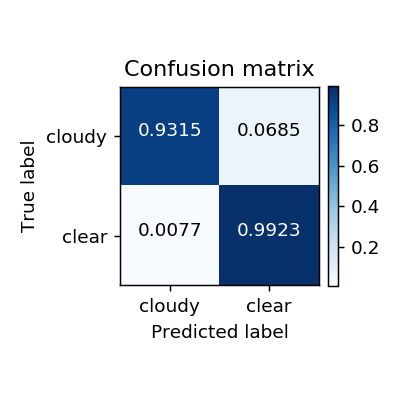

In [6]:
cols = ['GHI', 'Clearsky GHI', 'abs_diff_ratio', 'sky_status']
dt = tree.DecisionTreeClassifier()
dt = fit_model(dt, nsrdb_df, cols)

In [7]:
tree.export_graphviz(dt, out_file='2_b_abq_default_dt.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
# !dot -Tpng 2_b_abq_default_dt.dot -o 2_b_abq_default_dt.png

In [8]:
# Image('2_b_abq_default_dt.png')
# as before, this tree is a very large image.  view it outside the notebook for best results.

Tree is overly complex and difficult to interpret.  Will start by limiting the depth of the tree (using cross val).

### Max depth tree

<IPython.core.display.Javascript object>


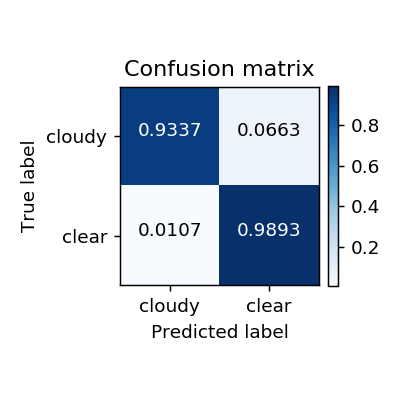

In [9]:
cols = ['GHI', 'Clearsky GHI', 'abs_diff_ratio', 'sky_status']
param_grid = {'max_depth': [i for i in range(2, 15)]}
dt = tree.DecisionTreeClassifier()
clf_cv = fit_model_cv_grid(dt, nsrdb_df, cols, param_grid)
dt = clf_cv.best_estimator_

In [10]:
print('Optimal max depth: ', dt.max_depth)
MAX_DEPTH = dt.max_depth

Optimal max depth:  5


In [11]:
tree.export_graphviz(dt, out_file='2_b_abq_opt_dt.dot', feature_names=cols[:-1], class_names=['cloudy', 'clear'])
!dot -Tpng 2_b_abq_opt_dt.dot -o 2_b_abq_opt_dt.png

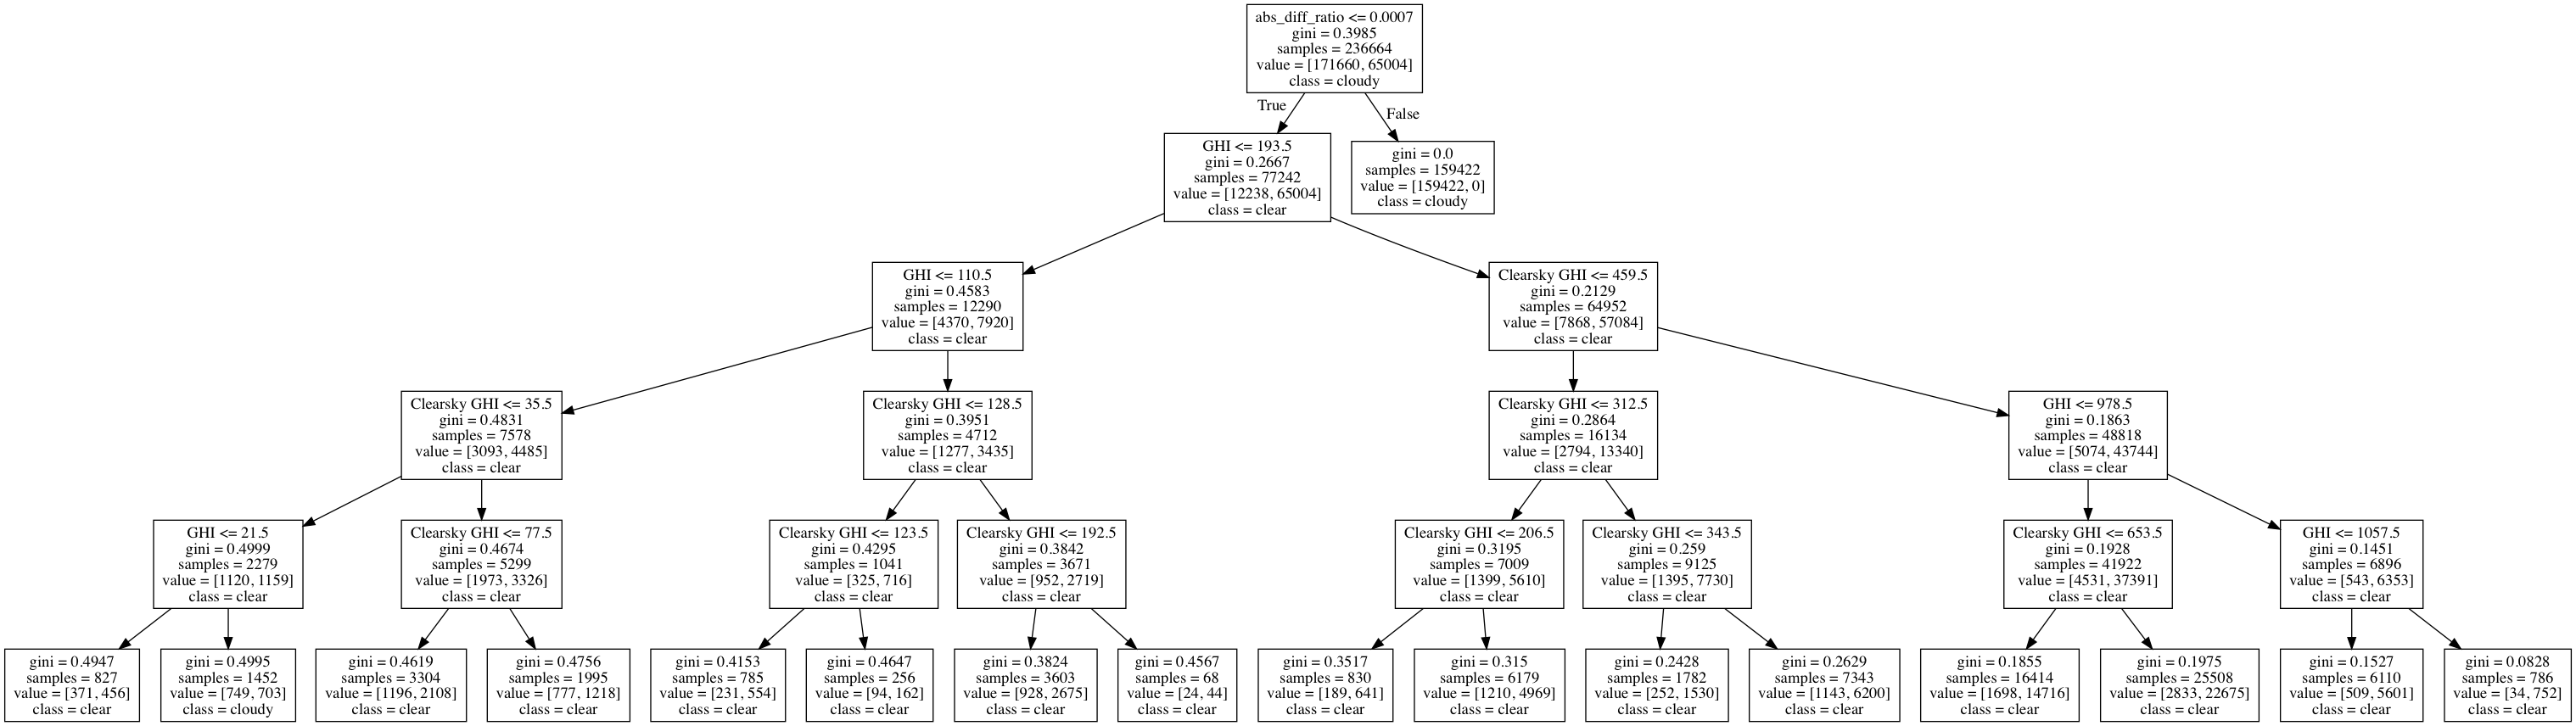

In [12]:
Image('2_b_abq_opt_dt.png')

<IPython.core.display.Javascript object>


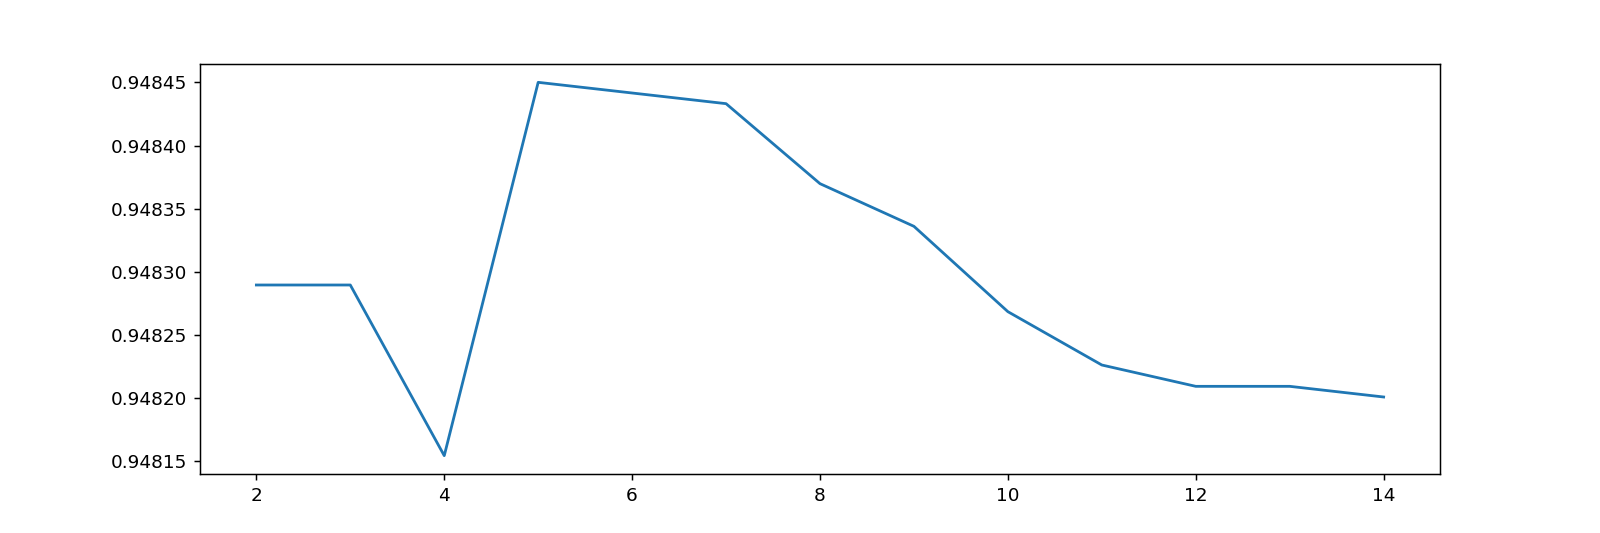

In [13]:
scores = clf_cv.cv_results_['mean_test_score']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(list(range(2, 15)), scores)

Again, a depth of 6 isn't much better than a depth of 2/3 which can be more easily interpreted.  We'll stick to 6 for now.

## Abs diff ratio

In [14]:
train_df = nsrdb_df[nsrdb_df.index < '01-01-2015']
test_df = nsrdb_df[nsrdb_df.index >= '01-01-2015']

In [15]:
cols = ['GHI', 'Clearsky GHI', 'abs_diff_ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [16]:
predicted_clear = dt.predict(test_df[cols[:-1]])

<IPython.core.display.Javascript object>


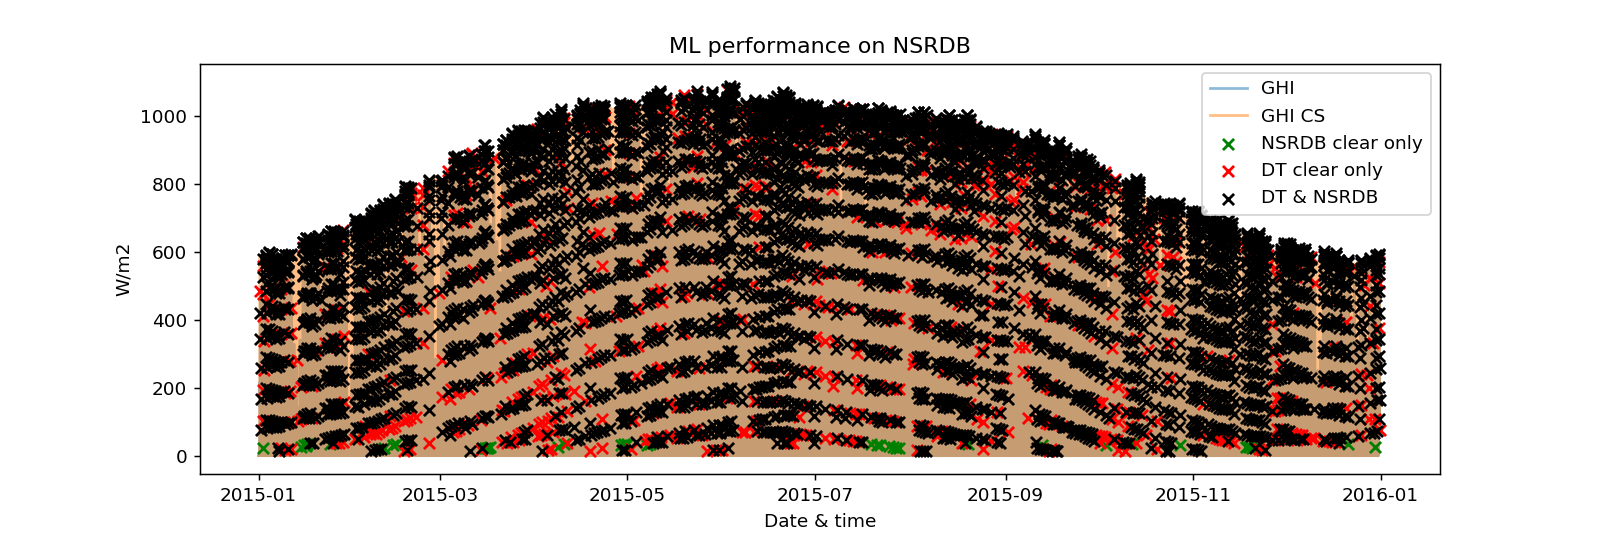

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(predicted_clear) & (test_df['sky_status'] == 1)].index, 
                test_df[~(predicted_clear) & (test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)].index, 
                test_df[(predicted_clear) & ~(test_df['sky_status'] == 1)]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['sky_status'] == 1) & (predicted_clear)].index,
                test_df[(test_df['sky_status'] == 1) & (predicted_clear)]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


From the eye test, performance looks good.  DT labels many more points than NSRDB, though they don't look obviously wrong.

## Test on ground data

## First run

In [18]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [20]:
cols = ['GHI', 'Clearsky GHI', 'abs_diff_ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [21]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

/Users/benellis/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


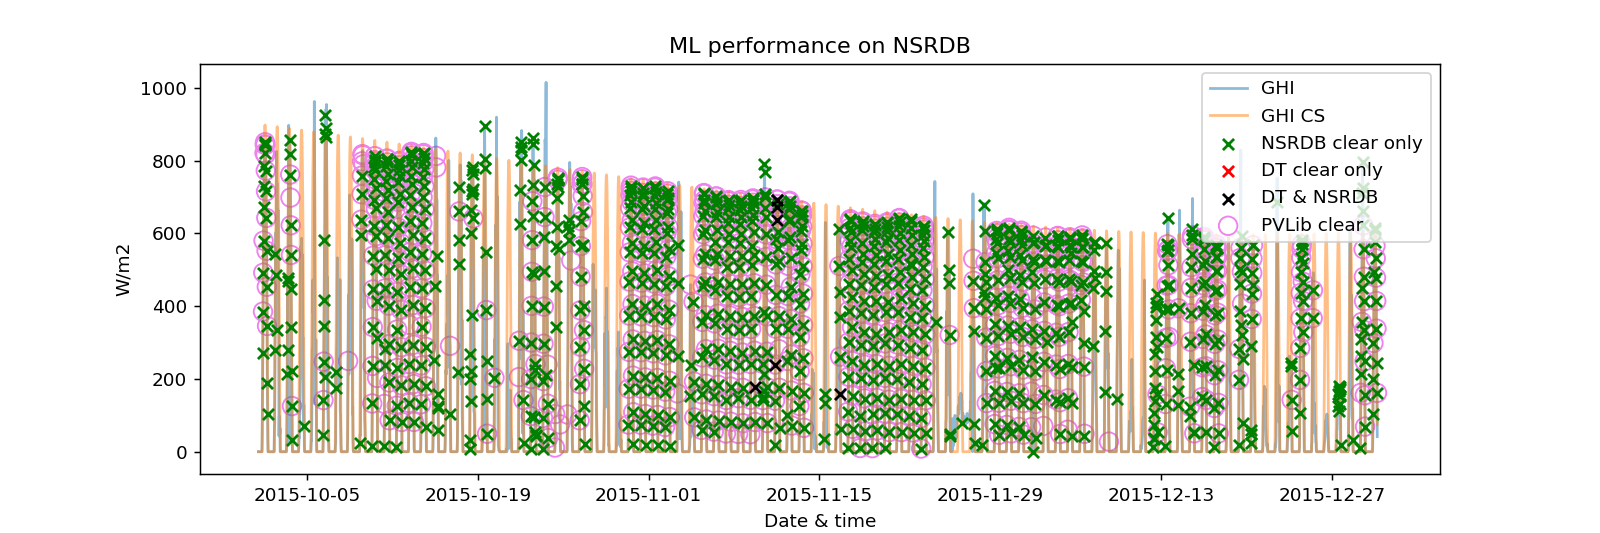

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p5 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status']].index,
                test_df[test_df['sky_status']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


Disappointing performance.  We expected this to at least be similar to the previous notebook's results (2_abq_dt_exploration).  It could be a scaling issue again though, so we will test that.

## Second run

Scale the clearsky model from PVLib using the alpha from the fit of PVLib detection procedure.

In [24]:
train_df = nsrdb_df
test_df = ground_df[ground_df.index >= '10-01-2015']

In [29]:
cols = ['GHI', 'Clearsky GHI', 'abs_diff_ratio', 'sky_status']
dt = tree.DecisionTreeClassifier(max_depth=MAX_DEPTH)
dt.fit(train_df[cols[:-1]].values, train_df[cols[-1]].values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [30]:
cols = ['GHI', 'Clearsky GHI scale', 'abs_diff_ratio scale', 'sky_status']

In [31]:
test_df['dt_clear'] = dt.predict(test_df[cols[:-1]])

In [32]:
train_df = train_df.loc[intersection]
test_df = test_df.loc[intersection]

<IPython.core.display.Javascript object>


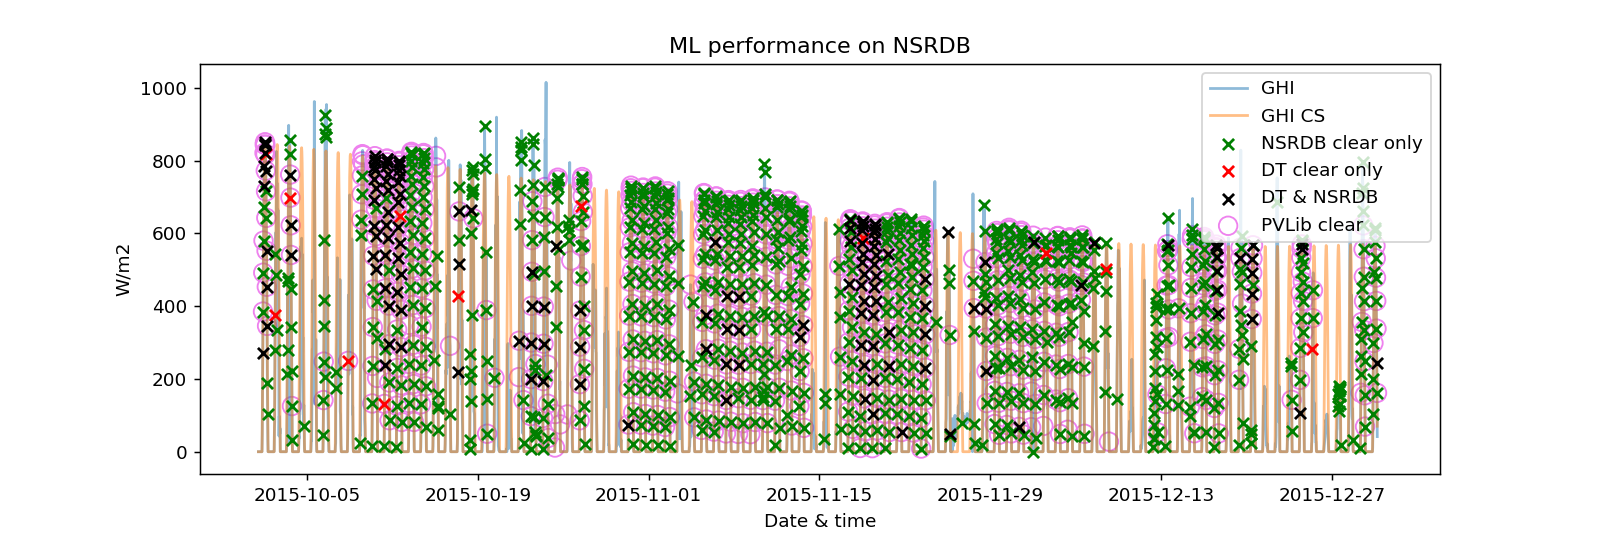

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

p1 = ax.plot(test_df.index, test_df['GHI'], label='GHI', alpha=.5)
p2 = ax.plot(test_df.index, test_df['Clearsky GHI scale'], label='GHI CS', alpha=.5)

p3 = ax.scatter(test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[~(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='green', label='NSRDB clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & ~(train_df['sky_status'])]['GHI'],
                marker='x', color='red', label='DT clear only', zorder=10)

p4 = ax.scatter(test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])].index,
                test_df[(test_df['dt_clear'] == 1) & (train_df['sky_status'])]['GHI'],
                marker='x', color='black', label='DT & NSRDB', zorder=10)

p6 = ax.scatter(test_df[test_df['sky_status']].index,
                test_df[test_df['sky_status']]['GHI'],
                marker='o', edgecolor='violet', facecolor='none', s=100, label='PVLib clear')

_ = ax.legend().set_zorder(100)

_ = ax.set_title('ML performance on NSRDB')
_ = ax.set_xlabel('Date & time')
_ = ax.set_ylabel('W/m2')


Performance almost unchanged, and scaling definitely isn't as helpful as it was when using the ratio.  This should be further investigated.